In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import cv2


from tqdm.notebook import tqdm_notebook as tqdm

import os
img_width, img_height = 224, 224


In [ ]:
print(os.listdir("/content/drive/MyDrive/dataset-20221209T060920Z-001/dataset/training"))

['real', 'fake']


In [ ]:
real = "/content/drive/MyDrive/dataset-20221209T060920Z-001/dataset/training/real"
fake = "/content/drive/MyDrive/dataset-20221209T060920Z-001/dataset/training/fake"

real_path = os.listdir(real)
fake_path = os.listdir(fake)

In [ ]:
dataset_path = "/content/drive/MyDrive/dataset-20221209T060920Z-001/dataset/training"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

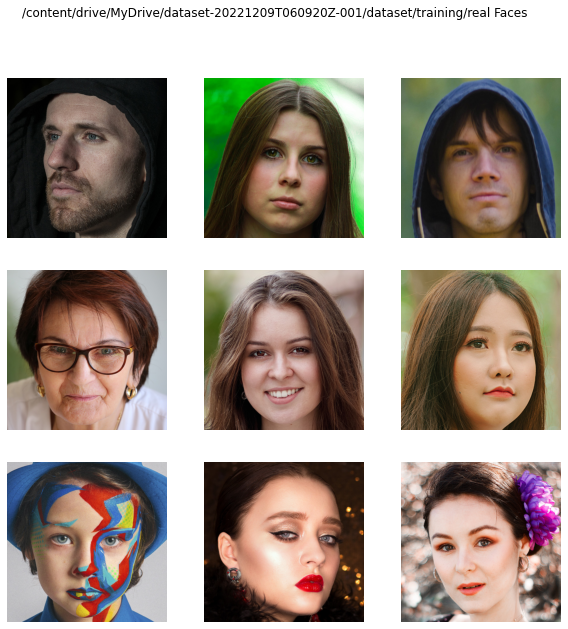

In [ ]:
def plot_img(dataset_path, set_):
    dir_ = os.path.join(dataset_path, 'train', set_)
    k = 0
    fig, ax = plt.subplots(3,3, figsize=(10,10))
    fig.suptitle(set_ + 'Faces')
    for j in range(3):
        for i in range(3):
            img = load_img(os.path.join(dir_, os.listdir(os.path.join(dir_))[k]))
            ax[j,i].imshow(img)
            ax[j,i].set_title("")
            ax[j,i].axis('off')
            k +=1
  #  fig.tight_layout()
    plt.suptitle(set_ + ' Faces')
    return plt

plot_img(dataset_path, '/content/drive/MyDrive/dataset-20221209T060920Z-001/dataset/training/real').show()

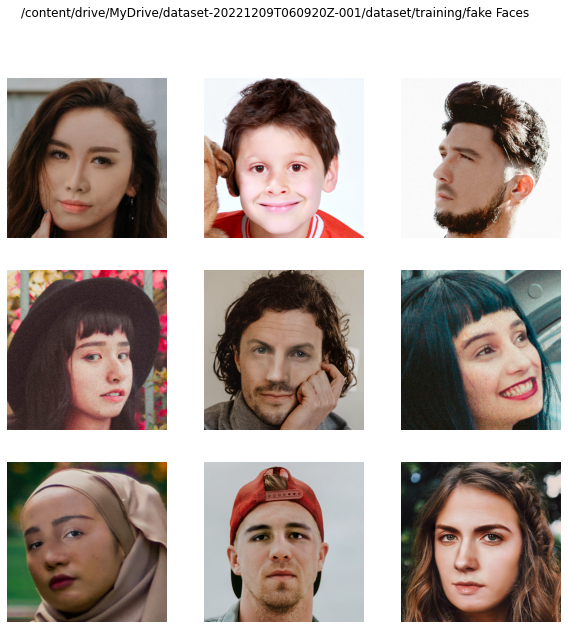

In [ ]:
plot_img(dataset_path, '/content/drive/MyDrive/dataset-20221209T060920Z-001/dataset/training/fake').show()

In [ ]:
data_with_aug = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                  validation_split=0.2)

In [ ]:
train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="training")

val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="validation"
                                          )

Found 1151 images belonging to 2 classes.
Found 286 images belonging to 2 classes.


In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
vgg16_model.output[-1]

<KerasTensor: shape=(7, 7, 512) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [ ]:



model = Sequential([vgg16_model,
                    Flatten(),Dense(2, activation = "softmax")])

model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
hist =  model.fit_generator(train,
                    epochs=30,
                    callbacks=[lr_callbacks],
                    validation_data=val)

<ipython-input-15-5c9835cf9134>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist =  model.fit_generator(train,


Epoch 1/30
12/12 [==============================] - 48s 3s/step - loss: 1.6063 - accuracy: 0.5317 - val_loss: 0.9372 - val_accuracy: 0.4720 - lr: 0.0010
Epoch 2/30
12/12 [==============================] - 21s 2s/step - loss: 0.9492 - accuracy: 0.5517 - val_loss: 0.8795 - val_accuracy: 0.5420 - lr: 0.0010
Epoch 3/30
12/12 [==============================] - 20s 2s/step - loss: 0.6550 - accuracy: 0.6664 - val_loss: 1.0005 - val_accuracy: 0.5280 - lr: 0.0010
Epoch 4/30
12/12 [==============================] - 21s 2s/step - loss: 0.5597 - accuracy: 0.7202 - val_loss: 0.7861 - val_accuracy: 0.5944 - lr: 1.0000e-04
Epoch 5/30
12/12 [==============================] - 20s 2s/step - loss: 0.5097 - accuracy: 0.7341 - val_loss: 0.8109 - val_accuracy: 0.5874 - lr: 1.0000e-04
Epoch 6/30
12/12 [==============================] - 20s 2s/step - loss: 0.4935 - accuracy: 0.7507 - val_loss: 0.7874 - val_accuracy: 0.6014 - lr: 1.0000e-04
Epoch 7/30
12/12 [==============================] - 20s 2s/step - loss

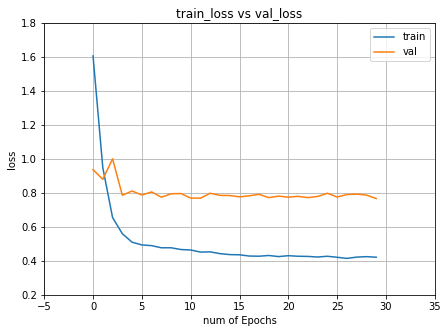

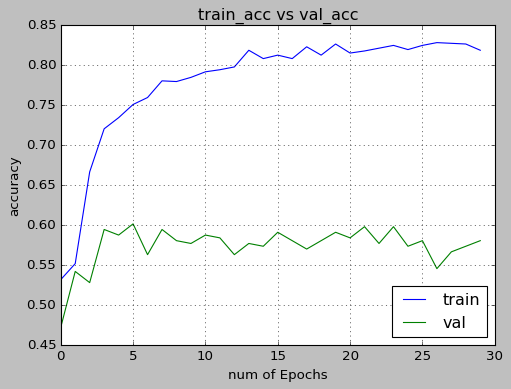

In [ ]:
epochs = 30
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])

In [ ]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/saved model/model.h5')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/saved model/model.h5')

1/1 [==============================] - 8s 8s/step
Predicted Class (0 - Real , 1- Fake):  0


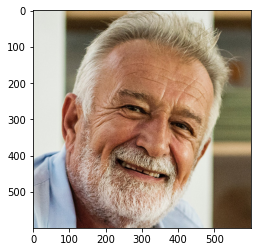

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
path_1=('/content/drive/MyDrive/dataset-20221209T060920Z-001/dataset/test/real/real_00807.jpg')
testImage = img.imread(path_1)
plt.imshow(testImage)
model = load_model('/content/drive/MyDrive/saved model/model.h5')
image = load_img(path_1, target_size=(224, 224))
img = np.array(image)
img = img / 255.0
img = img.reshape(1,224,224,3)
label = model.predict(img)
def value():
  if label[0][0] <=0.5:
    return 0
  else:
    return 1
print("Predicted Class (0 - Real , 1- Fake): ", value())